# Large Movie Review Dataset v1.0

## Introduction
The Large Movie Review Dataset is a collection of 50,000 movie reviews for training a sentiment analysis model. The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). It also includes an additional 50,000 unlabeled documents for unsupervised learning.

The dataset is structured as follows:
- `train/pos`: Contains positive movie reviews.
- `train/neg`: Contains negative movie reviews.
- `test/pos`: Contains positive movie reviews.
- `test/neg`: Contains negative movie reviews.
- `train/unsup`: Contains unlabeled movie reviews.

The data was originally designed to be used for binary sentiment classification tasks using classical machine learning natural language processing methods such as bas_of_words, TF-IDF, Hidden Markov Models, etc. In this work, we aim to use modern techniques of machine learning and specifically deep learning methods to construct a model that does well in classifying the comments on films. Additionaly, we will be pretraining a model on these text data and then finetuning our model to the specific task of classifying these comments. Our aim in this is to create a model that can generate a positive or negative comment by himself when asked to.
Furthermore, we aim to build an unsupervised model that will be using the unlabeled data in our dataset to grasp patterns that makes a positive comment a positive one and a negative comment a negative one. This will be used in classification and also in generating positive comments and negative comments.

### Packages and assets

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install wordcloud
!pip install tiktoken
!pip install tensorflow

In [79]:
import os
import gzip
import shutil
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# text visualization, preparation and preprocessing
import nltk
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import string
import re
nltk.download('punkt_tab') # asset for word tokenization
nltk.download('stopwords') # asset for stopwords finding
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tiktoken

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook, we are going to take a deep look in deep learning methods for this specific task. We will be exploring a variety of deep learning models going from Recurrent Neural Networks, Long Short Term Memory to Transformers architecture.

In [2]:
os.makedirs("dataset", exist_ok=True)

In [3]:
urls = ["https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"]

In [4]:
for url in urls:
    filename = os.path.join("dataset", url.split("/")[-1])
    print(f"Downloading {filename} ...")
    urllib.request.urlretrieve(url, filename)

In [5]:
!tar -xvzf dataset/aclImdb_v1.tar.gz -C dataset/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_

## Data Visualization

In order to perform the task of classification more accurately, we first want to take a deep dive into the dataset and get a fundamental understanding of what is inside of it. In doing that, we will grasp what intuitively differentiates a positive comment from a negative one. If we can figure that out intuitively, we then assume machines to be also able to hence foresee a good or bad performance coming from our models.

In [6]:
train_path = 'dataset/aclImdb/train'
print(Path(train_path + '/pos').resolve())

/content/dataset/aclImdb/train/pos


We have two separate classes : negative comments and positive ones. To stay consistent, we will load positive comments together and then negative comments together and then analyze physically what makes the difference between these two sets in other words, which words are responsible for negative and positive comments generally.

In [7]:
def load_corpus_from_folder(folder_path: str) -> list:
    """
    Load text files from a specified folder and return their contents as a list of strings.
    Args:
        folder_path (str): The path to the folder containing text files.
    Returns:
        list: A list of strings, each containing the contents of a text file.
    """
    corpus = []
    for file_path in Path(folder_path).rglob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            corpus.append(f.read())
    return corpus

In [8]:
positive_corpus = load_corpus_from_folder(Path(train_path + '/pos'))
negative_corpus = load_corpus_from_folder(Path(train_path + '/neg'))

In [9]:
print(positive_corpus[0])
print(negative_corpus[0])
print(len(positive_corpus))
print(len(negative_corpus))

I saw this movie again as an assignment for my management class. Were to mainly comment on the different management styles and ideas on quality(of the product). I did rent this one back in the eighties and I remember it to be good(but not great)movie. I've always liked Michael Keaton's style and delivery. He was a perfect fit for the movie.<br /><br />I am surprised to see some of the low ratings for this movie. I grant you yes it's no Oscar winner but it does have decent comedic value. It's more of a subtle comedy rather than a all-out comedy farce. I also find some of those that felt this was an inaccurate film on cultural and business differences. I beg to differ. I grant you again that there are a lot of generalities and dramatizations but then again this is Hollywood film not a documentary. From what I've read about differences between Automakers on both sides of the Pacific at that time many of the principle ideas were accurate for the time.<br /><br />Some of the basic differenc

We have loaded the data into two distinct objects. positive_corpus is a list of positive comments and negative_corpus is a list of negative comments. We now want to transform them into dataframes in order to perform some basic operations on them and extract meaningful variables.

In [10]:
df_pos = pd.DataFrame({'text': positive_corpus})
df_neg = pd.DataFrame({'text': negative_corpus})

Before going into seeing what are the characteristics of each type of comment, we need to define stopwords. A stopword is a word that doesn't provide any additionnal information to the sentence. For example, articles or pronouns or adverbs and so on. Any word that doesn't give any additional meaning is a stopword. There are many of them in each and every language. Since we are using an English language dataset, we will use the English language stopwords.

In [11]:
stop_words = set(stopwords.words('english'))

### Positive Comments

In [12]:
df_pos['char_count'] = df_pos['text'].apply(len) # number of characters
df_pos['word_count'] = df_pos['text'].apply(lambda x: len(word_tokenize(x))) # number of words
df_pos['avg_word_length'] = df_pos['char_count'] / df_pos['word_count'] # not quite useful but yeah... why not ?
df_pos.head()

,text,char_count,word_count,avg_word_length
0,I saw this movie again as an assignment for my...,2259,477,4.735849
1,"Brian Dennehy, Bill Paxton, Joe Pantalino and,...",865,198,4.368687
2,It's hard to top this movie in several ways. E...,1278,249,5.132530
3,This wonderful 1983 BBC television production ...,2022,406,4.980296
4,Writer/Director/Co-Star Adam Jones is headed f...,661,141,4.687943


In [13]:
print("Basic statistics:\n", df_pos[['char_count', 'word_count', 'avg_word_length']].describe())

Basic statistics:
          char_count    word_count  avg_word_length
count  12500.000000  12500.000000     12500.000000
mean    1347.160240    284.782800         4.718008
std     1046.747365    217.563364         0.354419
min       70.000000     14.000000         2.221477
25%      695.000000    149.000000         4.496587
50%      982.000000    208.500000         4.714286
75%     1651.000000    352.000000         4.937500
max    13704.000000   2818.000000         6.432432


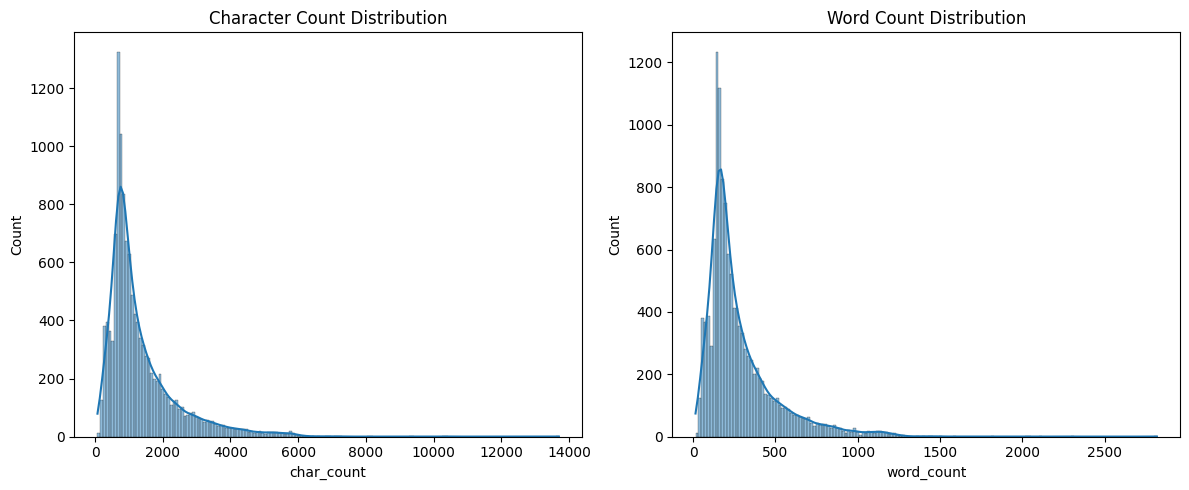

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_pos['char_count'], kde=True, ax=axes[0])
axes[0].set_title('Character Count Distribution')

sns.histplot(df_pos['word_count'], kde=True, ax=axes[1])
axes[1].set_title('Word Count Distribution')

plt.tight_layout()
plt.show()

In order to get insightful analysis, we need to do some cleaning to the comments before anything. Doing this means removing some useless things in the comments - by useless we mean words, tokens, group of words or tokens that does not provide any additional information to our comprehension. That means we need to remove the stopwords, case, punctuations, HTML tags (added surely when extracting the dataset from Imdb website) and urls.
In order, we will be doing these:
 - Remove HTML tags, URLs and mentions, Punctuations
 - Tokenize and remove stopwords and non-alphabetic tokens

In [15]:
def clean_text(text: str) -> str:
    """
    Clean string from useless words, tokens and return the cleaned string
    Args:
        text (str): string to be cleaned
    Returns:
        str: cleaned text
    """
    text = text.lower()

    # Remove HTML tags like <br/> and others
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenize and remove stopwords and non-alphabetic tokens
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and w.isalpha()]

    return " ".join(tokens)

In [16]:
df_pos['clean_text'] = df_pos['text'].apply(clean_text)

#### WordCloud

A word cloud is a visual representation of words that appear in a given text, where the size of each word corresponds to its frequency. The more often a word appears, the larger it will be in the cloud, making it easier to see the most common and important words.

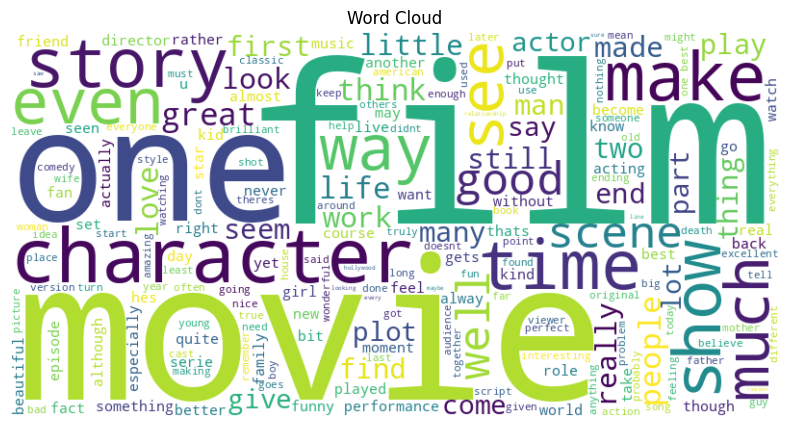

In [17]:
text_all = " ".join(df_pos['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

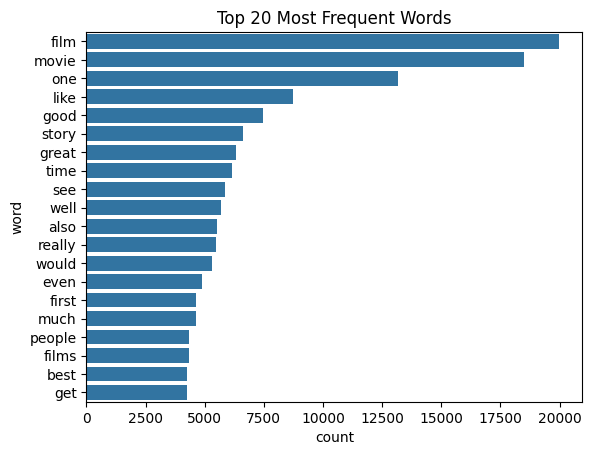

In [18]:
all_tokens = word_tokenize(text_all)
top_words = Counter(all_tokens).most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

sns.barplot(data=top_words_df, x='count', y='word')
plt.title("Top 20 Most Frequent Words")
plt.show()

#### Top Bigrams

In [19]:
def get_top_ngrams(texts, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

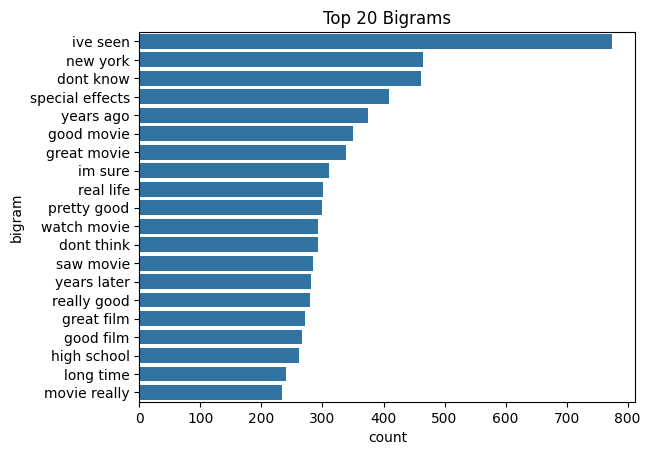

In [20]:
top_bigrams = get_top_ngrams(df_pos['clean_text'], (2,2))
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

sns.barplot(data=bigram_df, x='count', y='bigram')
plt.title("Top 20 Bigrams")
plt.show()

### Negative Comments

In [ ]:
df_neg['char_count'] = df_neg['text'].apply(len) # number of characters
df_neg['word_count'] = df_neg['text'].apply(lambda x: len(word_tokenize(x))) # number of words
df_neg['avg_word_length'] = df_neg['char_count'] / df_neg['word_count']
df_neg.head()

,text,char_count,word_count,avg_word_length
0,No mention if Ann Rivers Siddons adapted the m...,1206,250,4.824000
1,"To be as honest as I possibly can, The Devil's...",978,201,4.865672
2,"I haven't seen this movie in a while, so I'm a...",2279,501,4.548902
3,"I was expecting the movie based on Grendel, th...",766,172,4.453488
4,I'm going to spend as much time on this review...,814,163,4.993865


In [ ]:
print("Basic statistics:\n", df_neg[['char_count', 'word_count', 'avg_word_length']].describe())

Basic statistics:
          char_count    word_count  avg_word_length
count  12500.000000  12500.000000     12500.000000
mean    1302.979040    280.444720         4.641210
std      957.067769    203.486066         0.341931
min       52.000000     11.000000         2.755725
25%      709.000000    154.000000         4.428571
50%      976.500000    211.000000         4.642857
75%     1568.000000    338.000000         4.860425
max     8969.000000   1936.000000         6.470588


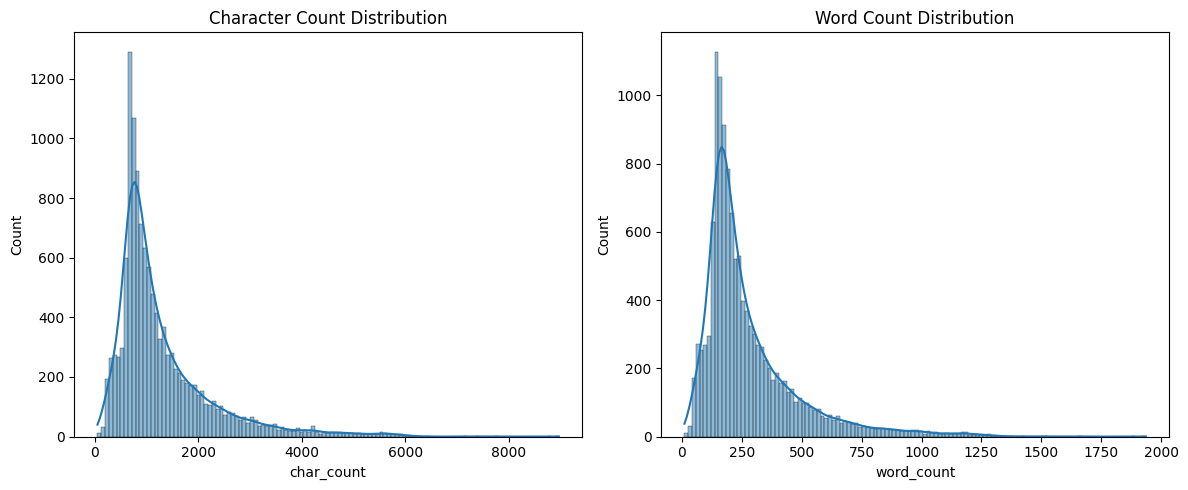

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_neg['char_count'], kde=True, ax=axes[0])
axes[0].set_title('Character Count Distribution')

sns.histplot(df_neg['word_count'], kde=True, ax=axes[1])
axes[1].set_title('Word Count Distribution')

plt.tight_layout()
plt.show()

In [ ]:
df_neg['clean_text'] = df_neg['text'].apply(clean_text)

#### WordCloud

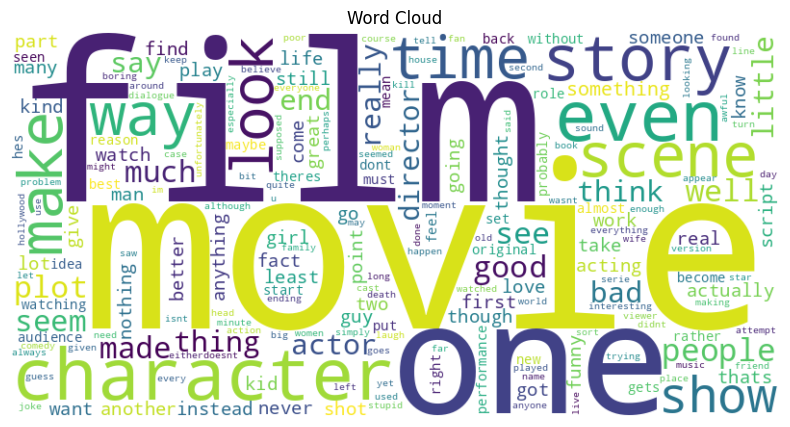

In [ ]:
text_all = " ".join(df_neg['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

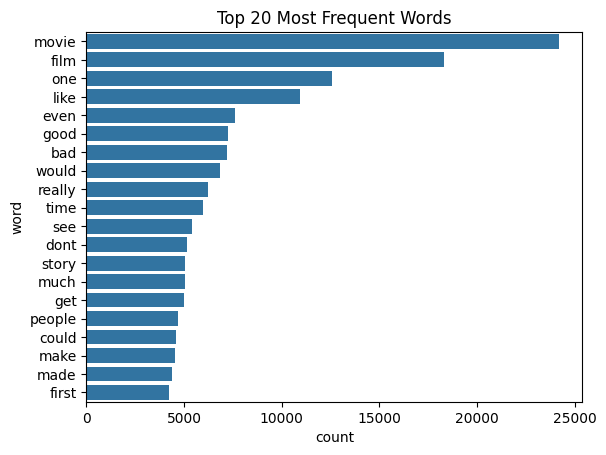

In [ ]:
all_tokens = word_tokenize(text_all)
top_words = Counter(all_tokens).most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

sns.barplot(data=top_words_df, x='count', y='word')
plt.title("Top 20 Most Frequent Words")
plt.show()

#### Top Bigrams

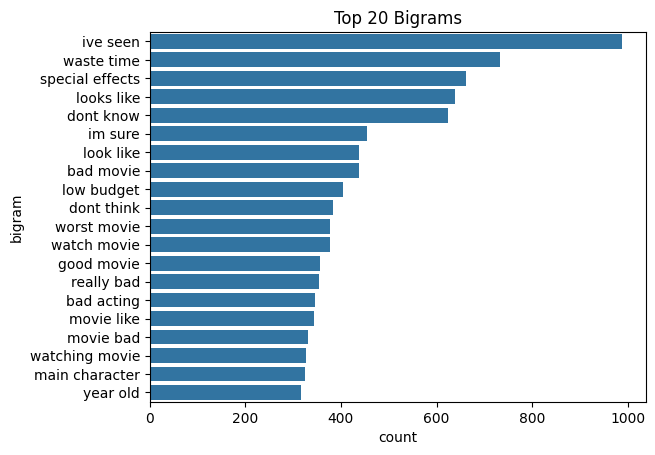

In [ ]:
top_bigrams = get_top_ngrams(df_neg['clean_text'], (2,2))
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

sns.barplot(data=bigram_df, x='count', y='bigram')
plt.title("Top 20 Bigrams")
plt.show()

## Classification Models

Most Deep Learning NLP models are designed for text generation. But most of them are adaptable to a classification problem like this one. In this section, we are going to be building some models for the sole purpose of classifying our comments into their classes. It's worth mentioning that the preparation procedure should be different for a task like text classification from a task like text generation.
In fact, for text classification, we don't need to keep every token present in the original text for the classification problem relies mostly on specific words in the comments. Some words don't provide any additional information (punctuations, stopwords, etc.). Thus, our treatment process will consist in loading the data into a dataframe and cleaning the text comments in order to get only the relevant words in the final text. Those cleaned texts will be the ones used in the training process. For text generation, every bit of text is important if we want to generate correct and human like text. We don't want here to clean the comments since even stopwords are used when we are interested in generating text. Though some informations are still not useful (For example URLs, HTML Tags). Here, our preparation procedure will consist in loading the text files and then cleaning it from those useless informations. The key rule is that stopwords are useful in this particular context.

### Data Preparation

As described before, here, we are going to prepare our dataset for the purpose of the classification. Our actions will be the following :
 - Load .txt files from `train/pos` and `train/neg` folders, get the comments into a dataframe
 - Shuffle our dataset randomly
 - Clean the comments by applying the `clean_text` function

In [80]:
def load_labeled_corpus(pos_path, neg_path):
    """
    Load and label text data from two folders (positive and negative samples), shuffle the combined dataset,
    and return it as a pandas DataFrame.

    Args:
        pos_path (str or Path): Path to the folder containing positive text files.
        neg_path (str or Path): Path to the folder containing negative text files.

    Returns:
        pandas.DataFrame: A shuffled DataFrame with two columns:
                          - 'text': the raw text content of each file.
                          - 'label': sentiment label (1 for positive, 0 for negative).
    """
    data = []
    for file_path in Path(pos_path).rglob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            data.append((f.read(), 1))  # positive = 1
    for file_path in Path(neg_path).rglob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            data.append((f.read(), 0))  # negative = 0
    return shuffle(pd.DataFrame(data, columns=['text', 'label']), random_state=42).reset_index(drop=True)

In [81]:
# Our loading function
train_path = 'dataset/aclImdb/train'
df = load_labeled_corpus(train_path + '/pos', train_path + '/neg')

In [82]:
test_path = 'dataset/aclImdb/test'
df_test = load_labeled_corpus(test_path + '/pos', test_path + '/neg')

In [83]:
df['clean_text'] = df['text'].apply(clean_text)

In [84]:
df_test['clean_text'] = df_test['text'].apply(clean_text)

In [85]:
df.head()

,text,label,clean_text
0,I give this movie an A+ for the sheer camp of ...,1,give movie sheer camp dietrichs daughter maria...
1,Ben Stiller doesn't so much act as react. And ...,0,ben stiller doesnt much act react well depende...
2,i don't care if you'd like my comment or no bu...,1,dont care youd like comment think write movie ...
3,This movie features two of my favorite actors ...,0,movie features two favorite actors kilmer down...
4,This was a disappointing film. The people seem...,0,disappointing film people seem substance lead ...


### Data Preprocessing

Data Preprocessing is the process of giving a specifc form to our data in order to make it suitable for the model we plan to use. In Natural Language Processing, this part is essential since the inputs are texts, we need to find a numerical representation for those texts. Texts are composed of sentences and sentences of words, words of characters. Characters are the base elements of human language but the don't hold meaning on their own. Words on the other hand hold meaning (solely or even depending on the context they are used in). In order to give a numerical representation to texts, we need to divide them into smaller elements which can be used in any sentence. This process in called tokenization. We therefore distinguish three types of tokenization :

- Word based tokenization : The text is broken down into the words composing it. This makes it so that all words that are in the dataset will be included in the vocabulary (by default). This can lead to huge vocabulary size but generaly holds better understanding of each word. Another of its drawbacks is the fact that a word and its plural form are considered different words for example.
- Character based tokenization : The text is broken down into the characters (alphabet). This minimize the vocabulary size to only the characters that are in the alphabet but generaly fails to grasp the meaning of words
- Subword based tokenization (somewhere in the middle) : More complex but it can grasp the concept of root word, prefix and suffix pretty well. Generaly used in text generation algortithms, it leads to smaller vocabulary size than word based yet bigger than character based and grasp meaning of words better.

In addition to that, since we are using a model, there should be a fixed length of text entering in it. Thus we need to define a maximum length (or context length). Sequences longer than that will be truncated and sequences shorter will be padded with zeros.

Here, we will be trying word based and subword based tokenization types and we will define maximum length to be 500. The vocabulary will be reduced to 20000.

In [86]:
MAX_VOCAB = 20000
MAX_LEN = 500

#### Word Tokenization

The `MAX_VOCAB` parameter will be used to restrict the size of the vocabulary to that maximum number of words. That means the top 50000 most frequent words will be included in the vocabulary and the others will be considered as `Out of Vocabulary (OOV)` words.

In [87]:
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token = "<OOV>") # we define our tokenizer, default: word based
tokenizer.fit_on_texts(df['clean_text']) # we fit it on our dataset

In [193]:
tokenizer_json = tokenizer.to_json()
with open('drive/MyDrive/models/tokenizers/word.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [89]:
vocab = tokenizer.word_index
print(list(vocab.items())[:10])  # top 10 most frequent words

[('<OOV>', 1), ('movie', 2), ('film', 3), ('one', 4), ('like', 5), ('good', 6), ('even', 7), ('would', 8), ('time', 9), ('really', 10)]


Essentially, the vocabulary is a dictionary in which each word is a key and its associated value is an id corresponding to its position in the dictionary (in common sense, not in Python).

In [90]:
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=MAX_LEN)
y = df['label'].values

In [91]:
X_test = tokenizer.texts_to_sequences(df_test['clean_text'])
X_test = pad_sequences(X_test, maxlen=MAX_LEN)
y_test = df_test['label'].values

In [92]:
X

array([[   0,    0,    0, ...,   82,  220,  239],
       [   0,    0,    0, ...,    1, 2149,   12],
       [   0,    0,    0, ...,  251,   57, 1132],
       ...,
       [   0,    0,    0, ...,   12,  976, 1651],
       [   0,    0,    0, ...,  813,   27,   13],
       [   0,    0,    0, ...,    1,    1,    1]], dtype=int32)

We then construct our input `X` values by tokenizing our sequences and padding them to maximum length. Our label values `y` are just the classes of our comments.

#### Subword Tokenization

There are two main subword tokenization algorithms : WordPiece and Byte Pair Encoding (BPE in short). BPE starts with individual characters as tokens and iteratively merges the most frequent pair of tokens in a new token. It repeats until a desired vocabulary size is reached. WordPiece is similar to BPE but it uses a probabilistic likelihood to select merges and in addition, it denotes when a subword appears most likely at the end of a word or at the beginning with `##`.
In this context, we will use BPE as our subword tokenizer. While WordPiece is commonly used in bidirectional models like BERT, which learn representations by looking at the sequence from both directions, BPE is suitable for models like LSTMs that process the input left-to-right. Since our task involves understanding a comment in a sequential, left-to-right manner (e.g., using an LSTM), BPE is a good choice due to its simplicity and efficiency.

In [93]:
BPE_VOCAB = 5000
BPE_MAX_LEN = 500

In [94]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence
from tokenizers.processors import BertProcessing

In [95]:
bpe = Tokenizer(BPE(unk_token="[UNK]")) # our tokenizer is BPE

bpe.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
bpe.pre_tokenizer = Whitespace()

In [96]:
trainer = BpeTrainer(vocab_size=BPE_VOCAB, show_progress = True, special_tokens=["[UNK]"])

In [97]:
train_texts = df['clean_text'].tolist()

with open("train_texts.txt", "w", encoding="utf-8") as f:
    for line in train_texts:
        f.write(line + "\n")

In [98]:
bpe.train(files=["train_texts.txt"], trainer=trainer)

In [194]:
bpe.save("drive/MyDrive/models/tokenizers/bpe.json")

In [100]:
vocab = bpe.get_vocab()
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1])
for token, idx in sorted_vocab[100:200]:
    print(f"{idx}: {token}")

100: od
101: est
102: la
103: ess
104: ir
105: man
106: ab
107: ex
108: ght
109: po
110: ld
111: em
112: tr
113: ur
114: ever
115: ant
116: be
117: op
118: us
119: ut
120: is
121: end
122: fe
123: ter
124: id
125: ag
126: con
127: art
128: ould
129: thing
130: and
131: wor
132: ell
133: oun
134: like
135: ne
136: pro
137: ot
138: per
139: ous
140: for
141: ok
142: qu
143: ast
144: ill
145: ive
146: ther
147: char
148: ta
149: ation
150: tim
151: nt
152: get
153: way
154: ind
155: pl
156: ment
157: ate
158: atch
159: stor
160: ra
161: ver
162: so
163: ig
164: wh
165: ful
166: good
167: ear
168: int
169: der
170: ff
171: reat
172: bo
173: ist
174: charact
175: all
176: mu
177: watch
178: ge
179: story
180: thou
181: see
182: ong
183: ard
184: ome
185: jo
186: even
187: would
188: able
189: ity
190: sp
191: gu
192: ci
193: pt
194: gr
195: um
196: ound
197: time
198: ite
199: no


In [101]:
vocab

{'neg': 2261,
 'santa': 4129,
 'crew': 2338,
 'c': 3,
 'together': 828,
 'clearly': 1746,
 'incredible': 2415,
 'wedding': 3628,
 'an': 39,
 'sul': 1913,
 'on': 36,
 'sees': 2437,
 'ence': 240,
 'ave': 759,
 'outside': 2325,
 'promising': 4155,
 'whos': 2034,
 'artists': 4694,
 'critical': 4705,
 'ange': 727,
 'colle': 1336,
 'dy': 1181,
 'sides': 4758,
 'aff': 1836,
 'humanity': 3699,
 'qu': 142,
 'ns': 1222,
 'beha': 2708,
 'igno': 3652,
 'need': 549,
 'porary': 4137,
 'amer': 375,
 'barry': 4452,
 'wonder': 564,
 'joke': 2258,
 'season': 1528,
 'tape': 4304,
 'many': 319,
 'powerful': 2279,
 'minutes': 684,
 'chest': 3982,
 'shame': 2031,
 'when': 3333,
 'rout': 3719,
 'years': 453,
 'concer': 1917,
 'colum': 3933,
 'wast': 848,
 'feel': 398,
 'etc': 1400,
 'jim': 1897,
 'means': 1983,
 'pulled': 3877,
 'bat': 1664,
 'rous': 3629,
 'vide': 855,
 'likely': 2913,
 'ino': 1558,
 'side': 658,
 'female': 1688,
 'actual': 1839,
 'clau': 4466,
 'appropriate': 3570,
 'zombies': 2512,
 'doug

In [102]:
encoded = bpe.encode("This is a great example")
print(encoded.tokens)
print(encoded.ids)

['this', 'is', 'a', 'great', 'example']
[2711, 120, 1, 237, 1274]


In [103]:
df["clean_text"].iloc[1]

'ben stiller doesnt much act react well dependent comedy going around theres something mary standup hair scene works stiller trying keep straight face confronts marys two suitors unfunniest guy room scene hilarious along came polly formula breaks reasons difficult fathom stiller surrounded array comic talent hank azaria philip seymour hoffman get best lines said hoffman relies little much bodily humour know trouble go fart jokes raise laugh basketball scene hoffman hams completely overplayed though throws one predicament form shirtless opponent raise smile noticeably stillers reaction however everyone seems acting bubble little reaction hoffman stillers characters could played much much aniston reprises rachael role stiller ross joey crush rachael scenario polly bythenumbers romcom failing lacks heart dont root characters little bit work could deeper story end films failure comes poor writing worth watching pops tv slow night youll regret forking cash see'

In [104]:
encoded = bpe.encode(df["clean_text"].iloc[1])
print(encoded.tokens)
print(encoded.ids)

['ben', 'still', 'er', 'doesnt', 'much', 'act', 're', 'act', 'well', 'depend', 'ent', 'comedy', 'going', 'around', 'theres', 'something', 'mary', 'stand', 'up', 'hair', 'scene', 'works', 'still', 'er', 'trying', 'keep', 'straight', 'face', 'confront', 's', 'mar', 'ys', 'two', 'suit', 'ors', 'un', 'funniest', 'guy', 'room', 'scene', 'hilarious', 'along', 'came', 'pol', 'ly', 'formula', 'breaks', 'reasons', 'difficult', 'fath', 'om', 'still', 'er', 'surround', 'ed', 'arr', 'ay', 'comic', 'talent', 'h', 'ank', 'az', 'ar', 'ia', 'philip', 'sey', 'm', 'our', 'hoff', 'man', 'get', 'best', 'lines', 'said', 'hoff', 'man', 're', 'lies', 'little', 'much', 'b', 'od', 'ily', 'humour', 'know', 'trouble', 'go', 'f', 'art', 'jokes', 'ra', 'ise', 'laugh', 'bas', 'ket', 'ball', 'scene', 'hoff', 'man', 'h', 'ams', 'completely', 'over', 'played', 'though', 'throw', 's', 'one', 'pre', 'd', 'ic', 'am', 'ent', 'form', 'shir', 't', 'less', 'op', 'pon', 'ent', 'ra', 'ise', 'smile', 'notice', 'ably', 'still', 

In [105]:
X_bpe = []
for text in df['clean_text']:
    encoded = bpe.encode(text).ids
    padded =  [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_bpe.append(padded)

X_bpe = np.array(X_bpe)

In [106]:
X_bpe[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [107]:
X_test_bpe = []
for text in df_test['clean_text']:
    encoded = bpe.encode(text).ids
    padded =  [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_test_bpe.append(padded)

X_test_bpe = np.array(X_test_bpe)

#### Subword tokenization pretrained (GPT2)

In this section, we use the already trained tokenizer from GPT2 model. This model used Byte Pair Encoding methode to generate it's vocabulary. We assume this tokenization model to be better than the one we trained ourselves on a smaller dataset. We do this to find out if a better tokenization method allows the model to learn better.

In [108]:
import importlib

In [109]:
print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [110]:
sw_pretrained = tiktoken.get_encoding("gpt2")

In [111]:
df["clean_text"].iloc[1]
integers = sw_pretrained.encode(df["clean_text"].iloc[1], allowed_special={"<|endoftext|>"})
print(integers)
tokens = [sw_pretrained.decode_single_token_bytes(tok).decode('utf-8', errors='replace') for tok in integers]
print("Tokens:", tokens)

[11722, 991, 263, 46701, 881, 719, 6324, 880, 10795, 10997, 1016, 1088, 262, 411, 1223, 285, 560, 1302, 929, 4190, 3715, 2499, 991, 263, 2111, 1394, 3892, 1986, 42650, 285, 560, 82, 734, 6050, 669, 3684, 20935, 6386, 3516, 2119, 3715, 20105, 1863, 1625, 3278, 88, 10451, 9457, 3840, 2408, 277, 32910, 991, 263, 11191, 7177, 9048, 7401, 289, 962, 35560, 10312, 5206, 541, 384, 4948, 454, 289, 2364, 805, 651, 1266, 3951, 531, 289, 2364, 805, 16507, 1310, 881, 20734, 31049, 760, 5876, 467, 15189, 14532, 5298, 6487, 9669, 3715, 289, 2364, 805, 289, 4105, 3190, 625, 21542, 996, 12542, 530, 44472, 1296, 10147, 1203, 6125, 5298, 8212, 33752, 991, 364, 6317, 2158, 2506, 2331, 7205, 14310, 1310, 6317, 289, 2364, 805, 991, 364, 3435, 714, 2826, 881, 881, 281, 36363, 302, 18166, 374, 620, 3010, 2597, 991, 263, 686, 824, 2525, 2959, 19813, 374, 620, 3010, 8883, 3278, 88, 416, 8524, 17024, 9267, 785, 9894, 16523, 2612, 17666, 6808, 3435, 1310, 1643, 670, 714, 9211, 1621, 886, 7328, 5287, 2058, 3595, 3

In [112]:
X_sw_pretrained = []
for text in df['clean_text']:
    encoded = sw_pretrained.encode(text, allowed_special={"<|endoftext|>"})
    padded =  [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_sw_pretrained.append(padded)

X_sw_pretrained = np.array(X_sw_pretrained)

In [113]:
X_test_sw_pretrained = []
for text in df_test['clean_text']:
    encoded = sw_pretrained.encode(text)
    padded =  [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_test_sw_pretrained.append(padded)

X_test_sw_pretrained = np.array(X_test_sw_pretrained)

In [114]:
SW_PRETRAINED_VOCAB = sw_pretrained.n_vocab

### Model Creation

#### Long Short Term Memory

In [115]:
BATCH_SIZE = 64
VAL_SPLIT = 0.5

For the sake of computation and hyperparameters optimization, we will be transforming our X, y from arrays to tensors. We will then divide our tensor dataset into a training part and validation part. After that, we will be batching our inputs so that parameter optimizations are done more frequently than the should if we had only one batch. A batch refers to a subset of the training dataset used in one iteration of the training process. Instead of processing the entire dataset at once, which can be computationally expensive, the data is divided into smaller batches. Here we set `BATCH_SIZE` to be equal to 64. Finally, we set our batched dataset to be prefetched. Prefetching in TensorFlow datasets is a technique to improve the performance of your input pipeline. It overlaps the preprocessing of data with the model execution, so that the next batch of data is ready when the model finishes processing the current batch. This can significantly reduce training time by avoiding idle time while data is being loaded and processed. When set to `tf.data.AUTOTUNE` it tells tensorflow to dynamically tune the prefetch buffer size based on your environment.

##### Data Preprocessing

Word Tokenized

In [117]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=len(X), seed=42)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=len(X_test), seed=42)
val_size = int(len(X_test) * VAL_SPLIT)

train_dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = test_dataset.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Subword Tokenized

In [118]:
dataset_bpe = tf.data.Dataset.from_tensor_slices((X_bpe, y))
dataset_bpe = dataset_bpe.shuffle(buffer_size=len(X_bpe), seed=42)
test_dataset_bpe = tf.data.Dataset.from_tensor_slices((X_test_bpe, y_test))
test_dataset_bpe = test_dataset_bpe.shuffle(buffer_size=len(X_test_bpe), seed=42)
val_size = int(len(X_test_bpe) * VAL_SPLIT)

train_dataset_bpe = dataset_bpe.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_bpe = test_dataset_bpe.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_bpe = test_dataset_bpe.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Subword tokenized pretrained (GPT2)

In [119]:
dataset_sw_pretrained = tf.data.Dataset.from_tensor_slices((X_sw_pretrained, y))
dataset_sw_pretrained = dataset_sw_pretrained.shuffle(buffer_size=len(X_sw_pretrained), seed=42)
test_dataset_sw_pretrained = tf.data.Dataset.from_tensor_slices((X_test_sw_pretrained, y_test))
test_dataset_sw_pretrained = test_dataset_sw_pretrained.shuffle(buffer_size=len(X_test_sw_pretrained), seed=42)
val_size = int(len(X_test_sw_pretrained) * VAL_SPLIT)

train_dataset_sw_pretrained = dataset_sw_pretrained.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_sw_pretrained = test_dataset_sw_pretrained.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_sw_pretrained = test_dataset_sw_pretrained.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##### Model Architecture

Our model architecture will consist of :
- An Embedding layer : Its role is to create vector embedding of each token in our vocabulary based on our comments dataset. A vector embedding is a high dimensional representation of a token id which has the characteristic of somehow holding the meaning of that token. Here our vector dimension will be set to 128. That choice is not that random. In fact, for a word based tokenization, we have a larger vocabulary. Like we've said previously, a word and its plural form are considered two different words in our vocabulary for example. For such cases, we do not need a lot of dimensions to encode the meaning of these words since that word will have its vector representation and his plural form will also have its vector representation such that they are close enough in the embedding space (Here, a 128 dimensional space).
- A Long Short Term Memory layer : With 64 units, this layer is responsible for the main prediction task. The LSTM is a type of Recurrent Neural Network (RNN in short) designed to capture dependencies over time while avoiding the vanishing or exploding gradients problem encountered in vanilla RNN. It uses memory cells and a gating mechanisms (input gate, forget gate, output gate) to select what to remember, what to forget and what to output.


 <div style="display: flex; align-items: center; justify-content: center; text-align: center">
  <img src="https://www.researchgate.net/profile/Ahmed-Elkaseer/publication/356018554/figure/fig1/AS:1088159563677697@1636448865987/A-Long-short-term-memory-LSTM-unit-architecture.png" style="width: 100%;">
 </div>

 The cell state is the long term memory and the hidden state is the short term memory. Based on the new input at time `t`, the forget gate tells the LSTM what percentage of the long term memory it should remember based on the new input (using a sigmoid activation function). For example, if our long term memory remembers informations about a cat and the new input talks about a dog (it's a totally new information), so based on the previous short term memory and our new input, the LSTM should (or should not) forget a percentage (can be large or small) of the long term memory. The input gate on the other hand combines previous short term memory and the new input to create a candidate long term memory (using a tanh activation function) and then determine what portion of the candidate memory it should add to the long term memory. Finally, the output gate uses the updated cell state (new long term memory) and a tanh activation function to determine what will be our candidate short term memory. Next, it uses a sigmoid activation function to find what percentage of the candidate short term memory should be our new short term memory (output). Each unit does that at each time step from 1 to the input length (T), here 500. At the end of the process, it outputs a 64 dimensional output for each sequence in our training data. At time step T, the LSTM has finished processing the last token of the sequence and it summarizes everything he has seen up to the Tth token.
 - A droput layer : A Dropout layer randomly sets a fraction of the output units (activations) to 0 during training. This helps prevent overfitting by forcing the network to not rely too heavily on any one feature. In this case, it takes effect on the LSTM output.
 - A dense layer : The dense layer is a simple feed forward network that uses a sigmoid function to make the classification

Our loss function is the `binary crossentropy function`, the optimizer `adam` and the metric is `accuracy`.

Word tokenized

In [128]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Training Loop

In [129]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose = 1,
    restore_best_weights=True
)

In [130]:
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7476 - loss: 0.4889 - val_accuracy: 0.8550 - val_loss: 0.3438
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9345 - loss: 0.1919 - val_accuracy: 0.8695 - val_loss: 0.3197
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9627 - loss: 0.1121 - val_accuracy: 0.8394 - val_loss: 0.5320
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9761 - loss: 0.0744 - val_accuracy: 0.8434 - val_loss: 0.6045
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [131]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 500, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,828,421 (29.86 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,218,948 (19.91 MB)

We now save our model if it has pretty decent performances on the testset

In [140]:
model.save("drive/MyDrive/models/classifiers/classifier_sentiment_word_tokenized_lstm_model.h5")

##### Learning curves

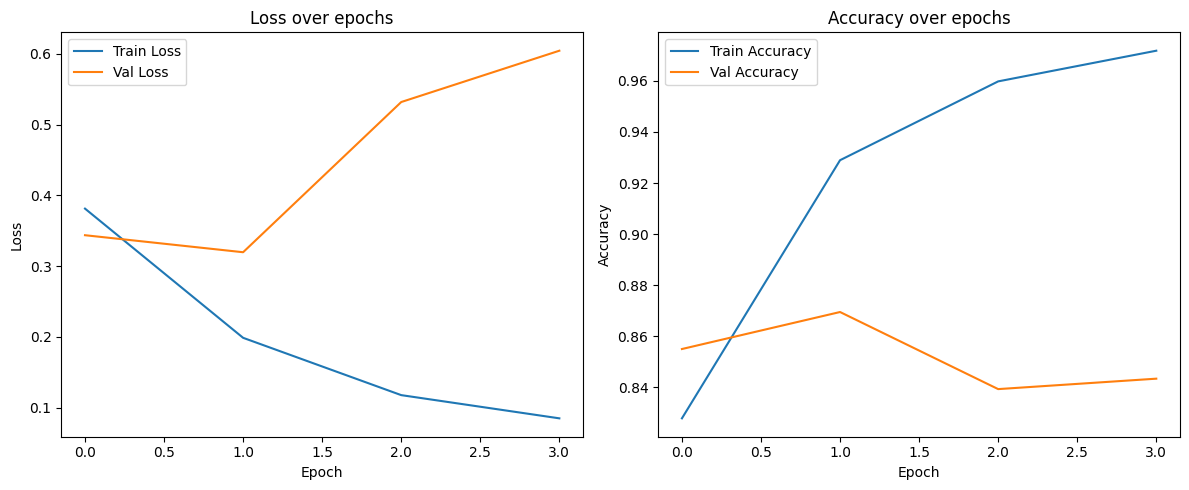

In [141]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Subword Tokenized

For the subword tokenized sequences, our model will have the same architecture except that we will have a smaller vocabulary, and larger output dimension for the embedding layer. For subword tokenization, we divide words into their small parts. For example, the word "trees" can be divided into two tokens "tree" and "s". So in this case, we need more dimension to encode the meaning of each token so that when combined it holds altogether the meaning of the word we want to express. Here token comprehension is essential.

In [142]:
model_bpe = Sequential([
    Embedding(input_dim=BPE_VOCAB, output_dim=512, input_length=BPE_MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bpe.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bpe.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We set an early stopping callback. Depending on its configuratons, it helps regulate how the model training process should be managed when we have no more improve in loss minimisation.

In [143]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose = 1,
    restore_best_weights=True
)

In [144]:
history_lstm_bpe = model_bpe.fit(train_dataset_bpe, epochs=15, validation_data=val_dataset_bpe, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.7521 - loss: 0.5001 - val_accuracy: 0.7506 - val_loss: 0.5155
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8641 - loss: 0.3436 - val_accuracy: 0.8533 - val_loss: 0.3482
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9074 - loss: 0.2405 - val_accuracy: 0.8625 - val_loss: 0.3404
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9327 - loss: 0.1825 - val_accuracy: 0.8570 - val_loss: 0.3546
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9449 - loss: 0.1496 - val_accuracy: 0.8414 - val_loss: 0.4332
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9500 - loss: 0.1413 - val_accuracy: 0.8453 - val_loss: 0.4259
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [145]:
model_bpe.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 500, 512)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,123,333 (30.99 MB)

 Trainable params: 2,707,777 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,415,556 (20.66 MB)

In [191]:
model_bpe.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_lstm_model.h5")

##### Learning Curves

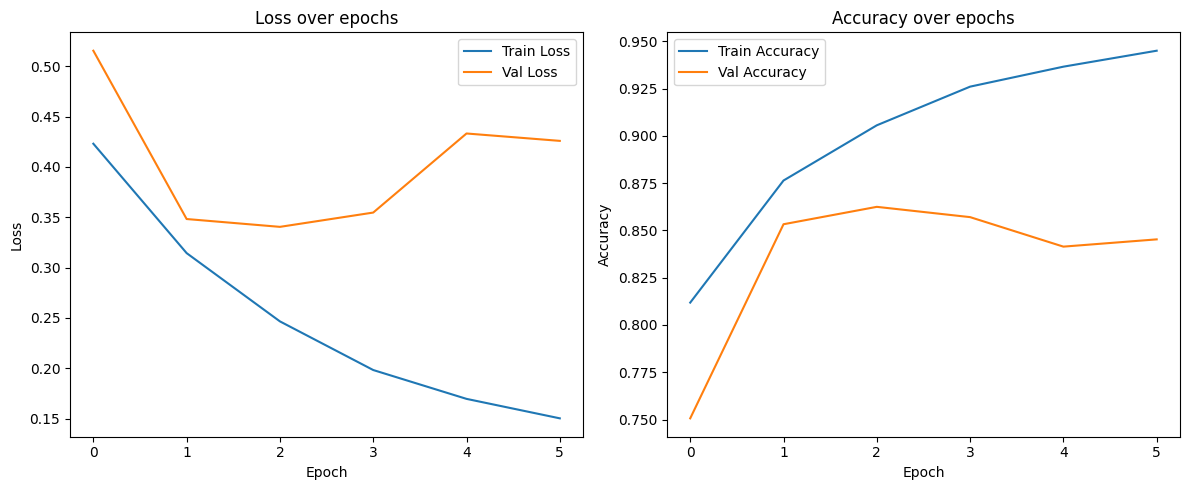

In [146]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm_bpe.history['loss'], label='Train Loss')
plt.plot(history_lstm_bpe.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm_bpe.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_bpe.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Subword tokenized pretrained (GPT2)

In [147]:
model_sw_pretrained = Sequential([
    Embedding(input_dim=SW_PRETRAINED_VOCAB, output_dim=512, input_length=BPE_MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_sw_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_sw_pretrained.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [148]:
history_lstm_sw_pretrained = model_sw_pretrained.fit(train_dataset_sw_pretrained, epochs=15, validation_data=val_dataset_sw_pretrained, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.7701 - loss: 0.4756 - val_accuracy: 0.8581 - val_loss: 0.3365
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9269 - loss: 0.2014 - val_accuracy: 0.8576 - val_loss: 0.3507
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9599 - loss: 0.1235 - val_accuracy: 0.8101 - val_loss: 0.5325
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9618 - loss: 0.1120 - val_accuracy: 0.8457 - val_loss: 0.4644
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [149]:
model_sw_pretrained.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 500, 512)       │    25,731,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,638,085 (296.17 MB)

 Trainable params: 25,879,361 (98.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,758,724 (197.44 MB)

In [190]:
model_sw_pretrained.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_pretrained_gpt2_lstm_model.h5")

##### Learning Curves

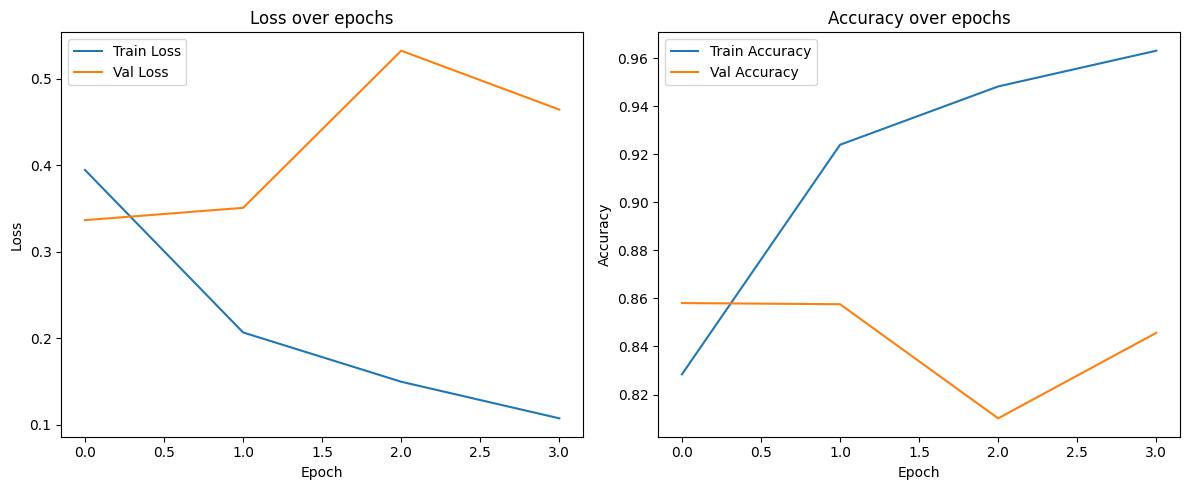

In [150]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm_sw_pretrained.history['loss'], label='Train Loss')
plt.plot(history_lstm_sw_pretrained.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm_sw_pretrained.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_sw_pretrained.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Models' Evaluation

Our models will be evaluated on two main datasets. The testset included in our original data composed of 25000 comments of films and Amazon reviews dataset. The first is to analyse the performance of the models on task tha have been trained on and the second is to see how well it performs when the comments are not on movies anymore and more on articles.
Our evaluation metrics are Loss and accuracy.

Word Tokenized

In [133]:
loss, accuracy = model.evaluate(test_dataset, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8716 - loss: 0.3156

Test Loss: 0.3177 - Test Accuracy: 0.8679


In [153]:
y_pred_probs = model.predict(X_test, batch_size=64)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87     12500
           1       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


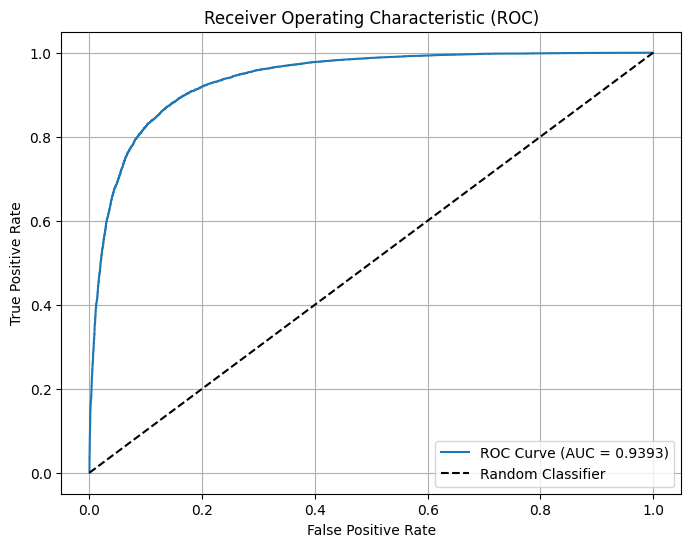

Meilleur seuil trouvé : 0.4756


In [137]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict(X_test, batch_size=64).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Meilleur seuil trouvé : {optimal_threshold:.4f}")

y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)


The optimal threshold is 0.4756. Less tha the original 0.5 threshold

In [138]:
y_pred_probs = model.predict(X_test, batch_size=64)
threshold = 0.4756
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



When faced with movie comments, our word tokenized model performs decently well (accuracy : 87%). Although there was some overfitting during the training, with the early callback, we successfully extracted meaningful results from our model training process.

In [155]:
amazon_url = "https://drive.google.com/file/d/1zp0ePkrgYqotoVrejwGe4ZvOcQzd5sxT/view?usp=drive_link"

In [157]:
import gdown

# file ID
file_id = "1zp0ePkrgYqotoVrejwGe4ZvOcQzd5sxT"
url = f"https://drive.google.com/uc?id={file_id}"

# Télécharger le fichier
output = "amazon_reviews.csv"
gdown.download(url, output, quiet=False)

# Lire le fichier
amazon_reviews = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1zp0ePkrgYqotoVrejwGe4ZvOcQzd5sxT
To: /content/amazon_reviews.csv
100%|██████████| 3.43M/3.43M [00:00<00:00, 23.9MB/s]


In Amazon Reviews dataset, we have comments (Text) and their scores (Score). The score is a rating of an article on a scale going from 1 to 5. This is different from the scale we have in our primary dataset (Imdb reviews). In that dataset, scores less than 4 are classified negative comments and scores greater than 7 are classified positive. The in-between scores are neutral. To stay consistent with that, with the Amazon reviews, we consider scores less than 3 negative and scores greater than 3 positive. Scores equal to 3 are neutral.

In [158]:
amazon_reviews.head()

,rating,text
0,5.0,"Amazon, please buy the show! I'm hooked!"
1,5.0,My Kiddos LOVE this show!!
2,3.0,Annabella Sciorra did her character justice wi...
3,4.0,...there should be more of a range of characte...
4,5.0,"...isn't always how you expect it to be, but w..."


In [159]:
amazon_reviews = amazon_reviews.dropna()
amazon_reviews = amazon_reviews[amazon_reviews['rating'] != 3] # we remove neutral scores

# 1 = positive (score > 3), 0 = negative (score < 3)
amazon_reviews['label'] = amazon_reviews['rating'].apply(lambda x: 1 if x > 3 else 0)

In [160]:
amazon_reviews['clean_text'] = amazon_reviews['text'].apply(clean_text)

In [161]:
amazon_reviews.head()

,rating,text,label,clean_text
0,5.0,"Amazon, please buy the show! I'm hooked!",1,amazon please buy show im hooked
1,5.0,My Kiddos LOVE this show!!,1,kiddos love show
3,4.0,...there should be more of a range of characte...,1,range characters highfunctioning autism jack c...
4,5.0,"...isn't always how you expect it to be, but w...",1,isnt always expect know movie deep struggles w...
5,5.0,As you learn about the very unique characters ...,1,learn unique characters values hold dear notic...


In [162]:
X_amazon = tokenizer.texts_to_sequences(amazon_reviews['clean_text'])
X_amazon = pad_sequences(X_amazon, maxlen=MAX_LEN)
y_amazon = amazon_reviews['label'].values

In [163]:
loss, accuracy = model.evaluate(X_amazon, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8298 - loss: 0.4018

Test Loss: 0.4098 - Test Accuracy: 0.8291


On this dataset, the model is performing just as much, showing that we didn't overfit during the process.

In [165]:
y_pred_probs = model.predict(X_amazon, batch_size=64)
threshold = 0.4756
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities
print(classification_report(y_amazon, y_pred))

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.42      0.79      0.55      1093
           1       0.97      0.85      0.91      8023

    accuracy                           0.84      9116
   macro avg       0.69      0.82      0.73      9116
weighted avg       0.90      0.84      0.86      9116



As we can see, with the optimal threshold, the model performs quite well in general but it's bad at classifying specifically the negative comments.

Subword Tokenized

In [ ]:
loss, accuracy = model_bpe.evaluate(X_test_bpe, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8319 - loss: 0.5968

Test Loss: 0.6018 - Test Accuracy: 0.8341


In [168]:
y_pred_probs = model_bpe.predict(X_test_bpe, batch_size=64)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


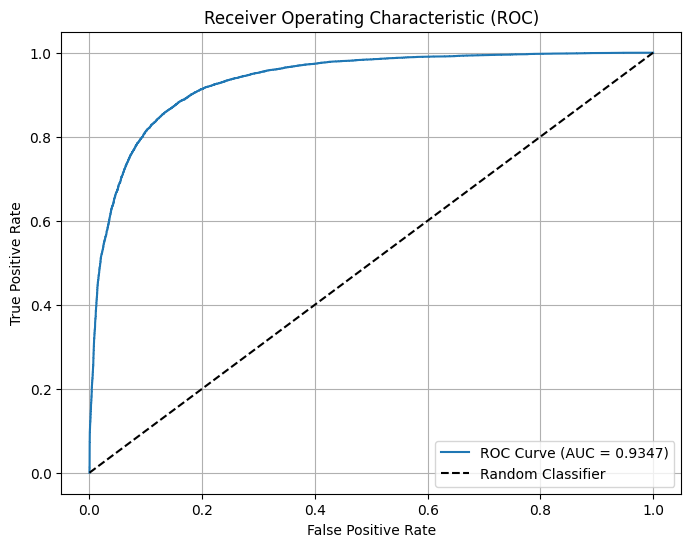

Meilleur seuil trouvé : 0.4820


In [170]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model_bpe.predict(X_test_bpe, batch_size=64).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Meilleur seuil trouvé : {optimal_threshold:.4f}")

y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)


In [175]:
y_pred_probs = model_bpe.predict(X_test_bpe, batch_size=64)
threshold = 0.4820
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     12500
           1       0.85      0.88      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In a nutshell, the subword tokenized model performs just as well as the previous one although a tiny little bit better.

In [173]:
X_amazon_bpe = []
for text in amazon_reviews['clean_text']:
    encoded = bpe.encode(text).ids
    padded =  [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_amazon_bpe.append(padded)

X_amazon_bpe = np.array(X_amazon_bpe)

In [174]:
loss, accuracy = model_bpe.evaluate(X_amazon_bpe, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8644 - loss: 0.3393

Test Loss: 0.3470 - Test Accuracy: 0.8664


In [177]:
y_pred_probs = model_bpe.predict(X_amazon_bpe, batch_size=64)
threshold = 0.4756
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities
print(classification_report(y_amazon, y_pred))

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.49      0.71      0.58      1093
           1       0.96      0.90      0.93      8023

    accuracy                           0.88      9116
   macro avg       0.72      0.80      0.75      9116
weighted avg       0.90      0.88      0.89      9116



The subword tokenized model performs a lot better than the word tokenized on the Amazon Reviews dataset and its performances are promising though not really satisfying yet. With more optimization of the parameters and a better model architecture, we could get a way better capacity to generalize. The subword tokenization decomposes each words into its components allowing it to capture more aspects of the human language than the word tokenization can do. This is key for the model to have a good understanding of the sequence and classify it better.

Subword tokenized pretrained (GPT2)

In [ ]:
loss, accuracy = model_sw_pretrained.evaluate(X_test_sw_pretrained, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8371 - loss: 0.7349

Test Loss: 0.7401 - Test Accuracy: 0.8357


In [178]:
y_pred_probs = model_sw_pretrained.predict(X_test_sw_pretrained, batch_size=64)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     12500
           1       0.83      0.91      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


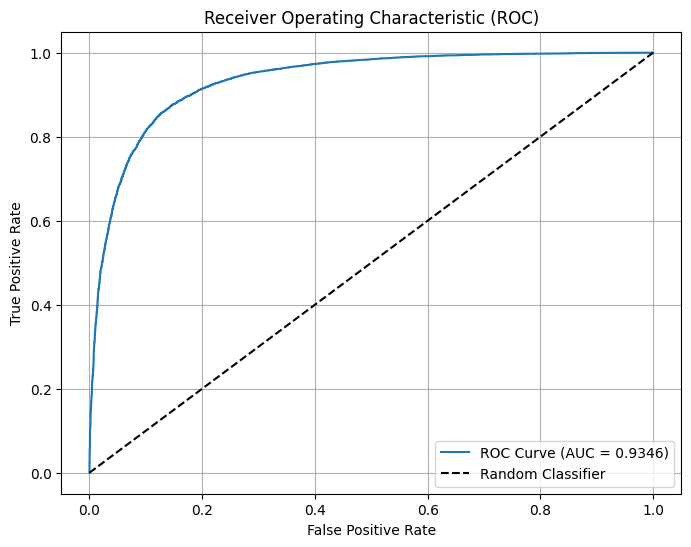

Meilleur seuil trouvé : 0.6195


In [181]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model_sw_pretrained.predict(X_test_sw_pretrained, batch_size=64).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Meilleur seuil trouvé : {optimal_threshold:.4f}")

y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)


In [182]:
y_pred_probs = model_sw_pretrained.predict(X_test_sw_pretrained, batch_size=64)
threshold = 0.6195
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [185]:
X_amazon_sw_pretrained = []
for text in amazon_reviews['clean_text']:
    encoded = sw_pretrained.encode(text)
    padded = [0] * (BPE_MAX_LEN - len(encoded)) + encoded[:BPE_MAX_LEN] if len(encoded) < BPE_MAX_LEN else encoded[:BPE_MAX_LEN]
    X_amazon_sw_pretrained.append(padded)

X_amazon_sw_pretrained = np.array(X_amazon_sw_pretrained)

In [187]:
loss, accuracy = model_sw_pretrained.evaluate(X_amazon_sw_pretrained, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8552 - loss: 0.3751

Test Loss: 0.3836 - Test Accuracy: 0.8519


In [189]:
y_pred_probs = model_sw_pretrained.predict(X_amazon_sw_pretrained, batch_size=64)
threshold = 0.6195
y_pred = (y_pred_probs > threshold).astype(int) # get the class from probabilities
print(classification_report(y_amazon, y_pred))

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.29      0.83      0.43      1093
           1       0.97      0.72      0.83      8023

    accuracy                           0.73      9116
   macro avg       0.63      0.78      0.63      9116
weighted avg       0.89      0.73      0.78      9116



#### Gated Recurrent Unit

Gated Recurrent Units (GRUs) are a type of Recurrent Neural Network (RNN) architecture designed to address the vanishing gradient problem and improve learning of long-term dependencies in sequential data. GRUs simplify the traditional Long Short-Term Memory (LSTM) architecture by combining the forget and input gates into a single update gate and using a reset gate to control how much past information to forget. Specifically, the update gate decides how much of the previous hidden state should be retained, while the reset gate determines how much of the past state to ignore when computing the new memory content. This streamlined structure allows GRUs to be computationally more efficient than LSTMs while still capturing complex temporal patterns, making them effective in tasks like language modeling, time series forecasting, and speech recognition.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*i-yqUwAYTo2Mz-P1Ql6MbA.png" style="width=100%">

##### Architecture

Word Tokenized

In [206]:
gru = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Training loop

In [207]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-3,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [208]:
history_gru = gru.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7151 - loss: 0.5264 - val_accuracy: 0.8694 - val_loss: 0.3163
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9241 - loss: 0.2074 - val_accuracy: 0.8663 - val_loss: 0.3311
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9611 - loss: 0.1195 - val_accuracy: 0.8560 - val_loss: 0.4030
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9814 - loss: 0.0632 - val_accuracy: 0.8539 - val_loss: 0.5061
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9874 - loss: 0.0395 - val_accuracy: 0.8336 - val_loss: 0.6526
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9922 - loss: 0.0274 - val_accuracy: 0.8368 - val_loss: 0.8915
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


##### Learning curves

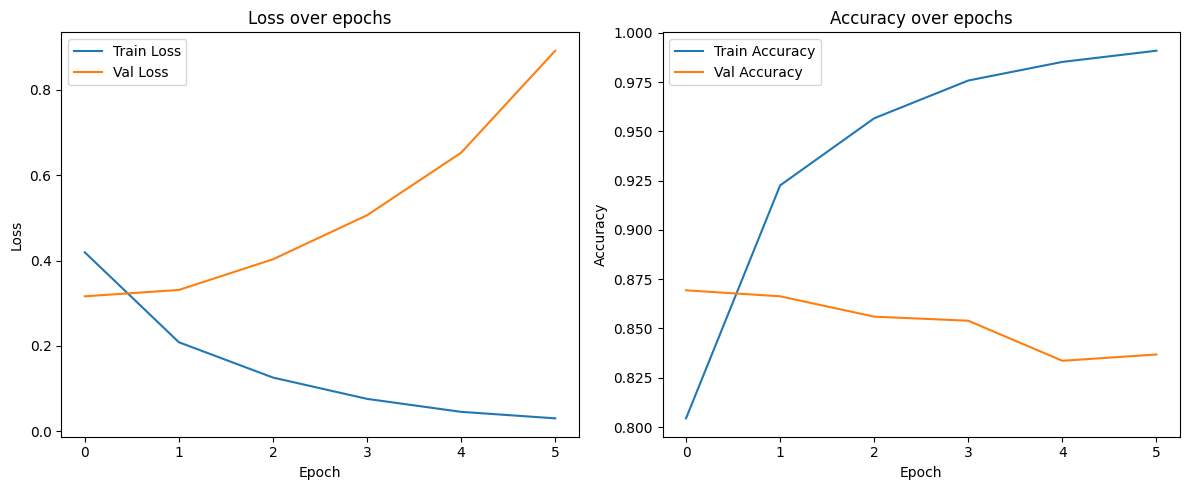

In [209]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [210]:
gru.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 500, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,791,941 (29.72 MB)

 Trainable params: 2,597,313 (9.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,194,628 (19.82 MB)

In [ ]:
gru.save("drive/MyDrive/models/classifiers/classifier_sentiment_word_tokenized_gru_model.h5")

Subword Tokenized

##### Architecture

In [212]:
gru_bpe = Sequential([
    Embedding(input_dim=BPE_VOCAB, output_dim=512, input_length=BPE_MAX_LEN),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_bpe.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_bpe.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Training Loop

In [213]:
history_gru_bpe = gru_bpe.fit(train_dataset_bpe, epochs=15, validation_data=val_dataset_bpe, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.7015 - loss: 0.5492 - val_accuracy: 0.8334 - val_loss: 0.3770
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8873 - loss: 0.2908 - val_accuracy: 0.8585 - val_loss: 0.3396
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9212 - loss: 0.2113 - val_accuracy: 0.8615 - val_loss: 0.3489
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9470 - loss: 0.1562 - val_accuracy: 0.8588 - val_loss: 0.3904
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9580 - loss: 0.1221 - val_accuracy: 0.8578 - val_loss: 0.4281
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9734 - loss: 0.0827 - val_accuracy: 0.8528 - val_loss: 0.4890
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9816 - loss: 0.0597 - val_accuracy: 0.8482 - val_loss: 0.5599
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


##### Learning Curves

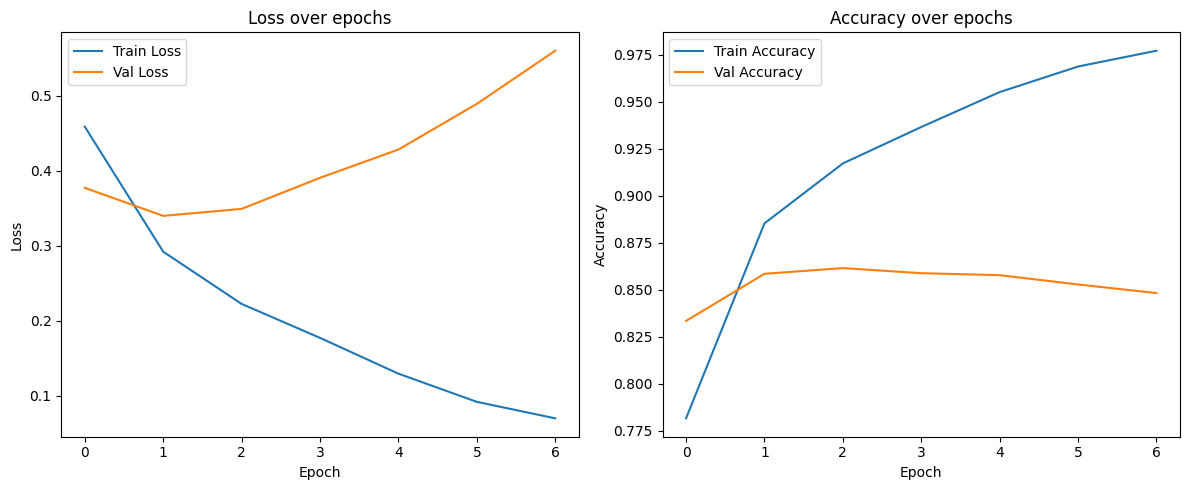

In [216]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_gru_bpe.history['loss'], label='Train Loss')
plt.plot(history_gru_bpe.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_gru_bpe.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru_bpe.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [215]:
gru_bpe.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 500, 512)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,013,125 (30.57 MB)

 Trainable params: 2,671,041 (10.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,342,084 (20.38 MB)

In [224]:
gru_bpe.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_gru_model.h5")

Subword Tokenized Pretrained (GPT2)

##### Architecture

In [217]:
gru_sw_pretrained = Sequential([
    Embedding(input_dim=SW_PRETRAINED_VOCAB, output_dim=512, input_length=BPE_MAX_LEN),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_sw_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_sw_pretrained.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Training Loop

In [218]:
history_gru_sw_pretrained = gru_sw_pretrained.fit(train_dataset_sw_pretrained, epochs=15, validation_data=val_dataset_sw_pretrained, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.7267 - loss: 0.5300 - val_accuracy: 0.8461 - val_loss: 0.3591
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9183 - loss: 0.2184 - val_accuracy: 0.8588 - val_loss: 0.3461
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9627 - loss: 0.1099 - val_accuracy: 0.8324 - val_loss: 0.4939
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9792 - loss: 0.0655 - val_accuracy: 0.8433 - val_loss: 0.5277
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9884 - loss: 0.0389 - val_accuracy: 0.8446 - val_loss: 0.5914
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9912 - loss: 0.0275 - val_accuracy: 0.8429 - val_loss: 0.6789
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9957 - loss: 0.0168 - val_accuracy: 0.8406 - val_loss: 0.8805
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


##### Learning Curves

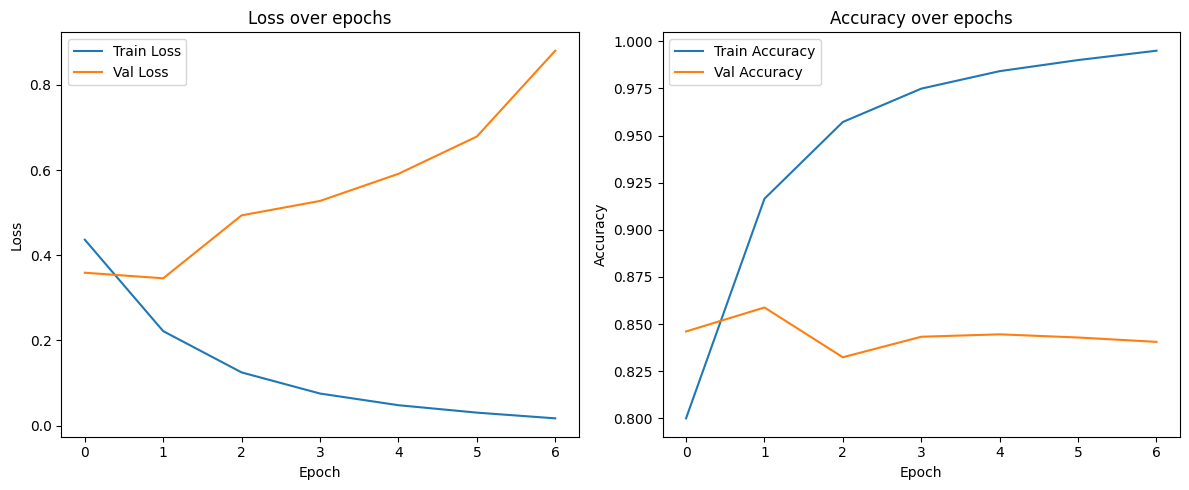

In [219]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_gru_sw_pretrained.history['loss'], label='Train Loss')
plt.plot(history_gru_sw_pretrained.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_gru_sw_pretrained.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru_sw_pretrained.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [220]:
gru_sw_pretrained.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 500, 512)       │    25,731,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,527,877 (295.75 MB)

 Trainable params: 25,842,625 (98.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,685,252 (197.16 MB)

In [223]:
gru_sw_pretrained.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_pretrained_gpt2_gru_model.h5")

##### Models' Evaluation

In [211]:
loss, accuracy = gru.evaluate(X_test, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8698 - loss: 0.3153

Test Loss: 0.3127 - Test Accuracy: 0.8707


In [252]:
loss, accuracy = gru.evaluate(X_amazon, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8803 - loss: 0.3363

Test Loss: 0.3358 - Test Accuracy: 0.8815


In [221]:
loss, accuracy = gru_bpe.evaluate(X_test_bpe, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8573 - loss: 0.3417

Test Loss: 0.3361 - Test Accuracy: 0.8602


In [253]:
loss, accuracy = gru_bpe.evaluate(X_amazon_bpe, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8924 - loss: 0.2848

Test Loss: 0.2835 - Test Accuracy: 0.8941


In [222]:
loss, accuracy = gru_sw_pretrained.evaluate(X_test_sw_pretrained, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8571 - loss: 0.3495

Test Loss: 0.3439 - Test Accuracy: 0.8582


In [254]:
loss, accuracy = gru_sw_pretrained.evaluate(X_amazon_sw_pretrained, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7885 - loss: 0.4328

Test Loss: 0.4539 - Test Accuracy: 0.7785


#### Transformer

In [225]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dropout, LayerNormalization
import numpy as np

In [226]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

In [227]:
# Multi-Head Attention
# splits the input tensor into three
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.wq = Dense(d_model) # query weights Wq
        self.wk = Dense(d_model) # key weights Wk
        self.wv = Dense(d_model) # value weights Wv
        self.dense = Dense(d_model) # Linear feed forward network output weights Wo

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q) # QWq
        k = self.wk(k) # KWk
        v = self.wv(v) # VWv
        q = self.split_heads(q, batch_size) # split QWq into h heads
        k = self.split_heads(k, batch_size) # split KWk into h heads
        v = self.split_heads(v, batch_size) # split VWv into h heads

        attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask) # compute attention on each head
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.d_model)) # concatenate all attentions
        output = self.dense(attention) # concat*Wo
        return output

    # attention function
    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights


In [228]:
# Positionwise Feed Forward Network
# The positionwise feed forward network is composed of two feed forward networks
# the first one has a relu activation function
class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(PositionwiseFeedforward, self).__init__()
        self.d_model = d_model
        self.dff = dff
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x


In [229]:
# Transformer Block
# A transformer block is composed of a multihead attention layer, a layer normalization layer,
# a point wise feed forward network and a layer normalization layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output = self.att(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2


In [230]:
# Encoder stack
# The encoder stack is composed of :
# Embedding : Embed tokens in high dimensional space
# Positional Encoding : Encode tokens position in high dimensional space
# stack of transformer blocks (n)
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        return x

# Decoder stack
# The decoder stack is composed of :
# Embedding : embed outputs (shifted right) in high dimensional space
# Positional encoding : encode tokens position in high dimensional space
# stack of transformer blocks (n)
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.dec_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, training=training, mask=look_ahead_mask)
        return x, attention_weights


In [231]:
# TransformerClassifier
# This is a modified transformer architecture
# Our transformer is composed just an encoder layer and a dense linear layer
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               vocab_size, maximum_position_encoding, dropout_rate)
        # self.decoder = Decoder(num_layers, d_model, num_heads, dff,
        #                        target_vocab_size, maximum_position_encoding, dropout_rate)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()

        self.classifier = tf.keras.Sequential([
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])

    def call(self, inputs, training=False, look_ahead_mask=None, padding_mask=None):
        inp = inputs
        enc_output = self.encoder(inp, training=training, mask=padding_mask)
        pooled = self.global_avg_pool(enc_output)
        # dec_output, _ = self.decoder(tar, enc_output, training=training,
        #                             look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
        # final_output = self.final_layer(dec_output)
        predictions = self.classifier(pooled, training=training)

        return predictions

    def create_padding_mask(self, seq):
        """Create padding mask for input sequences"""
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]


Subword Tokenized

In [243]:
trans = TransformerClassifier(
    num_layers=2,
    d_model=64,
    num_heads=4,
    dff=128,
    vocab_size=BPE_VOCAB,
    maximum_position_encoding=BPE_MAX_LEN,
    dropout_rate=0.1
)

In [244]:
trans.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [245]:
trans.summary()

Model: "transformer_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [246]:
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=2,               # Wait 5 epochs for improvement
    restore_best_weights=True,  # Revert to best weights seen on val_loss
    mode='min',               # We want to minimize val_loss
    verbose=1
)

In [247]:
history = trans.fit(train_dataset_bpe, validation_data=val_dataset_bpe, epochs=15, verbose=1, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.5104 - loss: 0.7178 - val_accuracy: 0.7147 - val_loss: 0.6295
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8342 - loss: 0.3764 - val_accuracy: 0.8379 - val_loss: 0.3472
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8917 - loss: 0.2687 - val_accuracy: 0.8203 - val_loss: 0.4032
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9051 - loss: 0.2397 - val_accuracy: 0.8712 - val_loss: 0.3083
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9179 - loss: 0.2105 - val_accuracy: 0.8694 - val_loss: 0.3259
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9294 - loss: 0.1900 - val_accuracy: 0.8706 - val_loss: 0.3258
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


In [248]:
trans.summary()

Model: "transformer_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │       386,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,161,029 (4.43 MB)

 Trainable params: 387,009 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774,020 (2.95 MB)

In [270]:
trans.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_transformer_model.h5")

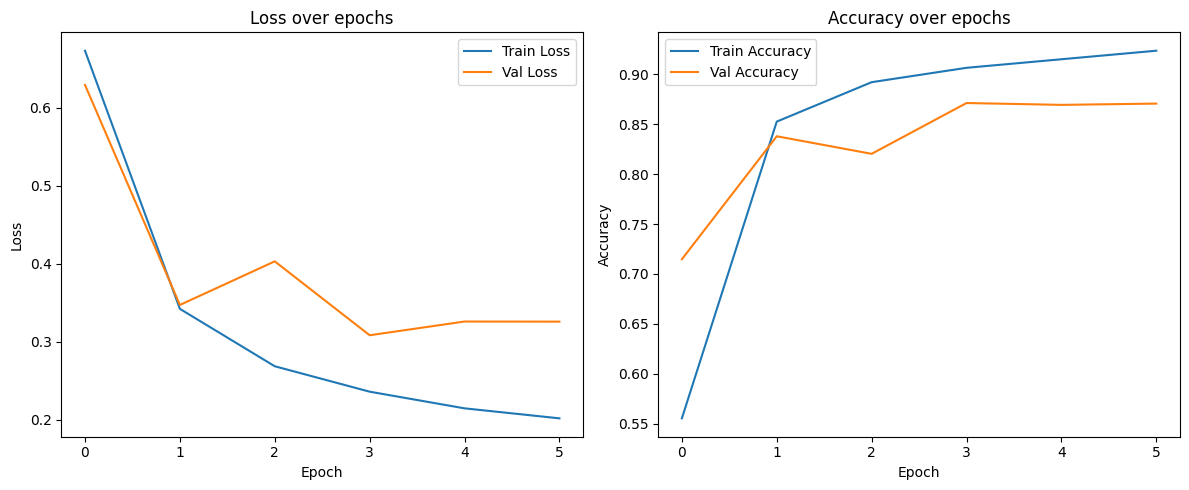

In [249]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Subword Tokenized pretrained (GPT2)

In [259]:
trans_sw_pretrained = TransformerClassifier(
    num_layers=2,
    d_model=64,
    num_heads=4,
    dff=128,
    vocab_size=SW_PRETRAINED_VOCAB,
    maximum_position_encoding=BPE_MAX_LEN,
    dropout_rate=0.1
)

In [260]:
trans_sw_pretrained.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [261]:
history = trans_sw_pretrained.fit(train_dataset_sw_pretrained, validation_data=val_dataset_sw_pretrained	, epochs=15, verbose=1, callbacks=[early_stop])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.5082 - loss: 0.7221 - val_accuracy: 0.7283 - val_loss: 0.5510
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8207 - loss: 0.3995 - val_accuracy: 0.8766 - val_loss: 0.2895
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9149 - loss: 0.2123 - val_accuracy: 0.8642 - val_loss: 0.3471
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9459 - loss: 0.1504 - val_accuracy: 0.8694 - val_loss: 0.3423
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [262]:
trans_sw_pretrained.summary()

Model: "transformer_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_4 (Encoder)             │ ?                      │     3,283,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_18 (Sequential)      │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,850,373 (37.58 MB)

 Trainable params: 3,283,457 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,566,916 (25.05 MB)

In [269]:
trans_sw_pretrained.save("drive/MyDrive/models/classifiers/classifier_sentiment_subword_tokenized_pretrained_gpt2_transformer_model.h5")

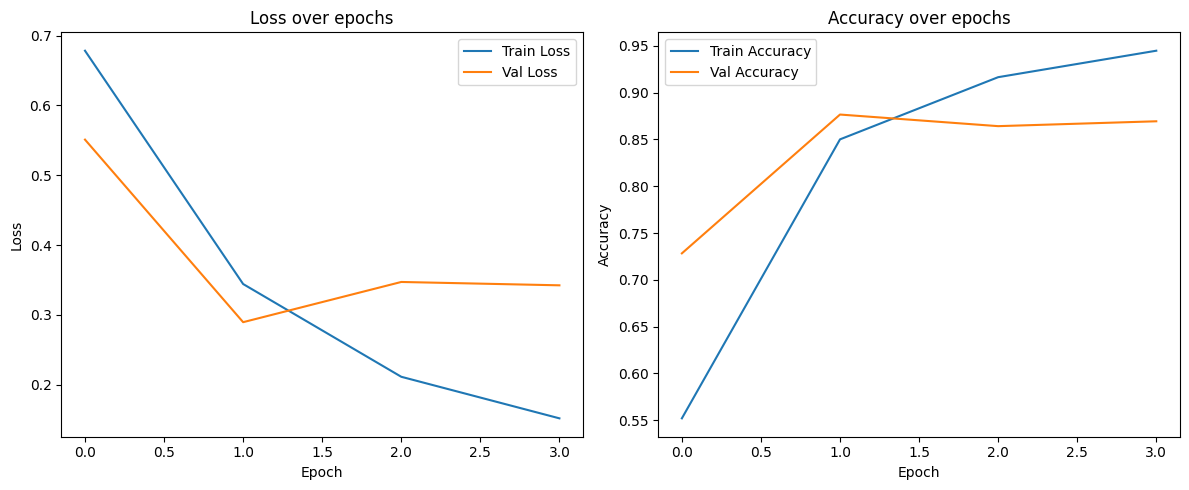

In [263]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Models' Evaluation

Sub word tokenized

In [264]:
loss, accuracy = trans.evaluate(X_test_bpe, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8710 - loss: 0.3068

Test Loss: 0.3016 - Test Accuracy: 0.8736


In [265]:
loss, accuracy = trans.evaluate(X_amazon_bpe, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8871 - loss: 0.2754

Test Loss: 0.2790 - Test Accuracy: 0.8872


In [266]:
loss, accuracy = trans_sw_pretrained.evaluate(X_test_sw_pretrained, y_test, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8758 - loss: 0.2971

Test Loss: 0.2908 - Test Accuracy: 0.8772


In [268]:
loss, accuracy = trans_sw_pretrained.evaluate(X_amazon_sw_pretrained, y_amazon, batch_size=64)
print(f"\nTest Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7948 - loss: 0.4461

Test Loss: 0.4693 - Test Accuracy: 0.7858


## Generative Models

In [3]:
import json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Movies_and_TV.jsonl.gz"

In [23]:
os.makedirs("amazon", exist_ok=True)

In [24]:
filename = os.path.join("amazon", url.split("/")[-1])
print(f"Downloading {filename} ...")
urllib.request.urlretrieve(url, filename)

('amazon/Movies_and_TV.jsonl.gz', <http.client.HTTPMessage at 0x7e7e1454c450>)

In [25]:
gz_path = "amazon/Movies_and_TV.jsonl.gz"

jsonl_path = "amazon/Movies_and_TV.jsonl"
print("Unzipping...")
with gzip.open(gz_path, 'rb') as f_in:
    with open(jsonl_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Unzip complete.")

os.remove(gz_path)
print("Deleted zipped file.")

Unzipping...
Unzip complete.
Deleted zipped file.


In [26]:
jsonl_path = "amazon/Movies_and_TV.jsonl"

with open(jsonl_path, 'r') as f:
    first_line = f.readline()
    first_item = json.loads(first_line)

print(first_item)

{'rating': 5.0, 'title': 'Five Stars', 'text': "Amazon, please buy the show! I'm hooked!", 'images': [], 'asin': 'B013488XFS', 'parent_asin': 'B013488XFS', 'user_id': 'AGGZ357AO26RQZVRLGU4D4N52DZQ', 'timestamp': 1440385637000, 'helpful_vote': 0, 'verified_purchase': True}


In [27]:
jsonl_path = "amazon/Movies_and_TV.jsonl"
chunk_size = 10000
max_chunks = 3  # Process only the first 30,000 lines (3 chunks)

data_chunks = []

with open(jsonl_path, 'r', encoding='utf-8') as f:
    for chunk_num in range(max_chunks):
        data = []
        for _ in range(chunk_size):
            line = f.readline()
            if not line:
                break  # EOF
            item = json.loads(line)

            rating = item.get("rating")
            text = item.get("text")
            data.append({"rating": rating, "text": text})

        if data:
            df = pd.DataFrame(data)
            df.to_csv(f"reviews_chunk_{chunk_num+1}.csv", index=False)
        else:
            break  # No more data

In [5]:
output_path = "/content/drive/MyDrive/reviews.txt"

In [ ]:
with open(jsonl_path, 'r', encoding='utf-8') as f_in, open(output_path, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        try:
            item = json.loads(line)
            if all(k in item for k in ['rating', 'title', 'text']):
                rating = str(item['rating']).strip()
                title = item['title'].strip().replace('\n', ' ')
                review = item['text'].strip().replace('\n', ' ')
                formatted = f"{rating} <|endofrating|> {title} <|endoftitle|> {review} <|endofreview|>\n"
                f_out.write(formatted)
        except json.JSONDecodeError:
            continue

Tokenizer

In [6]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace, ByteLevel
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence
from tokenizers.processors import BertProcessing

In [7]:
GEN_BPE_VOCAB = 8000

In [ ]:
tkn = Tokenizer(BPE(unk_token="<|unk|>"))
tkn.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
tkn.pre_tokenizer = ByteLevel()

In [ ]:
tkn_trainer = BpeTrainer(vocab_size=GEN_BPE_VOCAB, show_progress = True,
                         special_tokens=["<|unk|>", "<|pad|>", "<|endofrating|>", "<|endoftitle|>", "<|endofreview|>"])

In [ ]:
lines = []
with open(output_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 200000:
            break
        lines.append(line.strip())

In [ ]:
tkn.train_from_iterator(lines, tkn_trainer)

In [ ]:
tkn.save("/content/drive/MyDrive/bpe_tokenizer.json")

In [8]:
tkn = Tokenizer.from_file("/content/drive/MyDrive/bpe_tokenizer.json")

In [ ]:
vocab = tkn.get_vocab()

In [10]:
encoded = tkn.encode("This is a great example")
print(encoded.tokens)
print(encoded.ids)

['Ġthis', 'Ġis', 'Ġa', 'Ġgreat', 'Ġexample']
[220, 216, 155, 276, 2412]


In [ ]:
target_line = None

with open(output_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i == 100001:
            target_line = line.strip()
            break

if target_line is not None:
    encoded = tkn.encode(target_line)
    print(target_line)
    print("Tokens:", encoded.tokens)
    print("IDs:", encoded.ids)
else:
    print("Line 100001 does not exist.")

5.0 <|endofrating|> Spectacular scenery <|endoftitle|> My nationality is Italian,  I found myself looking more at the spectacular scenery than watching the movie.  I did watch it again;  it was very good. <|endofreview|>
Tokens: ['Ġ5', '.', '0', 'Ġ', '<|endofrating|>', 'Ġspectacular', 'Ġscenery', 'Ġ', '<|endoftitle|>', 'Ġmy', 'Ġnation', 'ality', 'Ġis', 'Ġitalian', ',', 'Ġ', 'Ġi', 'Ġfound', 'Ġmyself', 'Ġlooking', 'Ġmore', 'Ġat', 'Ġthe', 'Ġspectacular', 'Ġscenery', 'Ġthan', 'Ġwatching', 'Ġthe', 'Ġmovie', '.', 'Ġ', 'Ġi', 'Ġdid', 'Ġwatch', 'Ġit', 'Ġagain', ';', 'Ġ', 'Ġit', 'Ġwas', 'Ġvery', 'Ġgood', '.', 'Ġ', '<|endofreview|>']
IDs: [226, 18, 20, 118, 2, 3925, 1907, 118, 3, 296, 5248, 856, 216, 5095, 16, 118, 162, 858, 1598, 991, 385, 343, 166, 3925, 1907, 472, 513, 166, 236, 18, 118, 162, 435, 285, 202, 633, 31, 118, 202, 245, 356, 287, 18, 118, 4]


Input-Target Pairs

In [11]:
def gen(path, tokenizer, max_length=200, limit=100_000):
    count = 0
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if count >= limit:
                break
            line = line.strip()
            if not line:
                continue
            ids = tokenizer.encode(line).ids
            for i in range(1, len(ids)):
                input_seq = ids[:i]
                target = ids[i]

                # Pad
                if len(input_seq) >= max_length:
                    input_seq = input_seq[-max_length:]
                else:
                    input_seq = [0] * (max_length - len(input_seq)) + input_seq

                yield input_seq, target
            count += 1

# Create dataset
ds = tf.data.Dataset.from_generator(
    lambda: gen(output_path, tkn, max_length=200, limit=200_000),
    output_signature=(
        tf.TensorSpec(shape=(200,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

ds = ds.batch(128).prefetch(tf.data.AUTOTUNE)


In [12]:
for x, y in ds.take(1):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)
    print("First input sequence (token ids):", x[0].numpy())
    print("First target token id:", y[0].numpy())

Input shape: (128, 200)
Target shape: (128,)
First input sequence (token ids): [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 226]
First target token id: 18


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_light_transformer_model(vocab_size, max_length=500, d_model=64, num_heads=2, ff_dim=128, num_layers=1, dropout_rate=0.1):
    inputs = layers.Input(shape=(max_length,), dtype=tf.int32)

    # Token embeddings
    x = layers.Embedding(input_dim=vocab_size, output_dim=d_model)(inputs)

    # Positional embeddings
    pos_indices = tf.range(start=0, limit=max_length, delta=1)
    pos_embedding = layers.Embedding(input_dim=max_length, output_dim=d_model)(pos_indices)
    x = x + pos_embedding

    # Lightweight Transformer blocks
    for _ in range(num_layers):
        # Causal self-attention mask
        mask = tf.linalg.band_part(tf.ones((max_length, max_length)), -1, 0)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout_rate)(
            x, x, attention_mask=mask
        )
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn)

        # Feedforward
        ffn = layers.Dense(ff_dim, activation='relu')(x)
        ffn = layers.Dense(d_model)(ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)

    # Output logits (next-token prediction at the last position)
    logits = layers.Dense(vocab_size)(x)
    last_token_logits = logits[:, -1, :]

    return Model(inputs=inputs, outputs=last_token_logits)


In [17]:
model = build_light_transformer_model(
    vocab_size=tkn.get_vocab_size(),  # Replace with actual vocab size
    max_length=200
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 64)   │    512,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ add_3[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 200, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 200, 64)   │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200, 8000) │    520,000 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 8000)      │          0 │ dense_5[0][0]     │
│ (GetItem)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,065,472 (4.06 MB)

 Trainable params: 1,065,472 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(ds, epochs=5)

Epoch 1/5
 103758/Unknown 3669s 35ms/step - accuracy: 0.2395 - loss: 4.7838